# Make Dataset

In [ ]:
import os
import pandas as pd
from itertools import combinations
from sklearn.model_selection import train_test_split
from PIL import Image

# Path to your dataset folder
dataset_folder = 'Homework5_dataset/'

# List all image files in the dataset folder
image_files = [f for f in os.listdir(dataset_folder) if f.endswith('.jpg')]

# Create a DataFrame to store file paths and corresponding classes
df = pd.DataFrame({'File': image_files})

# Extract classes from the file names 
df['Class'] = df['File'].apply(lambda x: x.split('_')[1])

# Create a dictionary to map classes to their corresponding image files
class_to_files = df.groupby('Class')['File'].apply(list).to_dict()

# Generate triplets from the dataset
def generate_triplets(class_to_files):
    triplets = []
    for c in class_to_files.keys():
        # Create all possible combinations of images for each class
        combinations_list = list(combinations(class_to_files[c], 3))
        triplets.extend(combinations_list)
    return triplets

# Generate triplets from the dataset
triplets = generate_triplets(class_to_files)

# Save all triplets to a single CSV file
columns = ['Anchor', 'Negative', 'Positive']
all_triplets_df = pd.DataFrame(triplets, columns=columns)

csv_path = 'triplets.csv'
all_triplets_df.to_csv(csv_path, index=False)

# Libraries

In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader
from skimage import io
from sklearn.model_selection import train_test_split
from PIL import Image
from tqdm import tqdm
import torch.nn as nn
import torchvision.models as models

# Load Dataset

In [39]:
df = pd.read_csv('triplets.csv')
df.head(n=5)

,Anchor,Negative,Positive
1342,0048_c6s1_005326_01.jpg,0105_c6s1_036276_01.jpg,0048_c5s1_005251_01.jpg
3045,1430_c5s3_059340_03.jpg,0614_c3s2_019362_03.jpg,1430_c6s3_082342_01.jpg
3736,0390_c5s1_092748_05.jpg,0998_c6s3_016167_02.jpg,0390_c1s2_032241_02.jpg
2849,1391_c1s5_073416_01.jpg,0404_c2s1_095896_05.jpg,1391_c3s3_047203_03.jpg
2815,0208_c6s1_045126_01.jpg,1178_c2s2_164552_01.jpg,0208_c1s2_002716_02.jpg


In [16]:
image_dir = "Homework5_dataset/"

# Example

In [85]:
row = df.iloc[12]

# Read images using PIL
A_img = Image.open(image_dir + row['Anchor'])
P_img = Image.open(image_dir + row['Positive'])
N_img = Image.open(image_dir + row['Negative'])

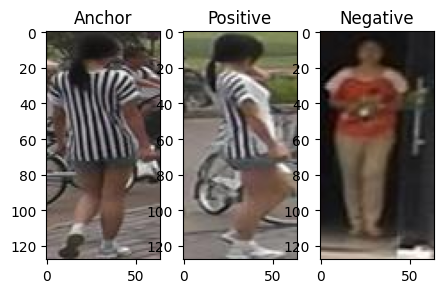

In [86]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (5,5))

ax1.set_title("Anchor")
ax1.imshow(A_img)

ax2.set_title("Positive")
ax2.imshow(P_img)

ax3.set_title("Negative")
ax3.imshow(N_img)

# Dataset split

In [17]:
train, valid = train_test_split(df, test_size = 0.20, random_state = 42)

# Normalizing

In [18]:
import torch
from PIL import Image
from torchvision import transforms

data_dir = "Homework5_dataset/"

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

def load_image(file_path):
    img = Image.open(data_dir + file_path).convert('RGB')
    img_tensor = transform(img)
    return img_tensor

def load_triplet(row):
    anchor_img = load_image(row.Anchor)
    positive_img = load_image(row.Positive)
    negative_img = load_image(row.Negative)

    return anchor_img, positive_img, negative_img

train_triplets = [load_triplet(row) for _, row in train.iterrows()]
valid_triplets = [load_triplet(row) for _, row in valid.iterrows()]

/root/miniconda3/envs/torch2/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [90]:
print(f"Size of trainset : {len(train_triplets)}")
print(f"Size of validset : {len(valid_triplets)}")

Size of trainset : 3200
Size of validset : 800


# Example

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


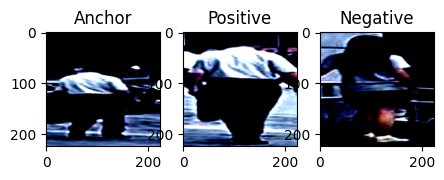

In [31]:
anchor, positive, negative = train_triplets[20]

f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(5, 5))

ax1.set_title('Anchor')
ax1.imshow(anchor.numpy().transpose((1, 2, 0)), cmap='gray')

ax2.set_title('Positive')
ax2.imshow(positive.numpy().transpose((1, 2, 0)), cmap='gray')

ax3.set_title('Negative')
ax3.imshow(negative.numpy().transpose((1, 2, 0)), cmap='gray')


# Loaders

In [19]:
train_loader = DataLoader(train_triplets, batch_size = 32,shuffle = True)
valid_loader = DataLoader(valid_triplets, batch_size = 32)

# Model

In [20]:
# Model Definition
class TripModel(nn.Module):
    def __init__(self, emb_size=512):
        super(TripModel, self).__init__()
        self.efficientnet = models.efficientnet_b0(pretrained=True)
        in_features = self.efficientnet.classifier[-1].in_features
        self.efficientnet.classifier[-1] = nn.Linear(in_features, emb_size)
    
    def forward(self, images):
        embeddings = self.efficientnet(images)
        return embeddings
    
model = TripModel()
model.to("cuda:1") 
print("Model Loaded")

Model Loaded


/root/miniconda3/envs/torch2/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/envs/torch2/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_B0_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_B0_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


# Triplet Loss

In [41]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomTripletMarginLoss(nn.Module):
    def __init__(self, margin=1.0):
        super(CustomTripletMarginLoss, self).__init__()
        self.margin = margin

    def euclidean_distance(self, x1, x2):
        return torch.sqrt(torch.sum((x1 - x2) ** 2, dim=1))

    def forward(self, anchor, positive, negative):
        distance_positive = self.euclidean_distance(anchor, positive)
        distance_negative = self.euclidean_distance(anchor, negative)

        loss = torch.clamp(distance_positive - distance_negative + self.margin, min=0.0).mean()

        return loss

criterion = CustomTripletMarginLoss(margin=1.0)
optimizer = torch.optim.Adam(model.parameters(), lr= 0.001)

# Train

In [38]:
import torch
from tqdm import tqdm
import numpy as np

device = "cuda:1" if torch.cuda.is_available() else "cpu"
model.to(device)
best_valid_loss = np.Inf

train_losses = []
valid_losses = []

for epoch in range(20):
    # Training
    model.train()
    total_train_loss = 0.0
    
    for A, P, N in tqdm(train_loader):
        A, P, N = A.to(device), P.to(device), N.to(device)
        
        A_embs = model(A)
        P_embs = model(P)
        N_embs = model(N)
        
        loss = criterion(A_embs, P_embs, N_embs)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        total_train_loss += loss.item()
    
    train_loss = total_train_loss / len(train_loader)
    train_losses.append(train_loss)

    
    # Validation
    model.eval()
    total_valid_loss = 0.0
    
    with torch.no_grad():
        for A, P, N in tqdm(valid_loader):
            A, P, N = A.to(device), P.to(device), N.to(device)
            
            A_embs = model(A)
            P_embs = model(P)
            N_embs = model(N)
            
            loss = criterion(A_embs, P_embs, N_embs)
            
            total_valid_loss += loss.item()
    
    valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(valid_loss)

    
    # Check if validation loss improved and save the model
    if valid_loss < best_valid_loss:
        torch.save(model.state_dict(), "best_model_triplet.pt")
        best_valid_loss = valid_loss
        print("SAVED_WEIGHT_SUCCESS")
    
    print(f"EPOCHS: {epoch+1} train_loss: {train_loss} valid_loss: {valid_loss}")


100%|██████████| 25/25 [00:02<00:00, 11.33it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 1 train_loss: 0.1901180087029934 valid_loss: 0.24415433675050735


100%|██████████| 25/25 [00:01<00:00, 18.40it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 2 train_loss: 0.1436317928880453 valid_loss: 0.13449892938137054


100%|██████████| 25/25 [00:01<00:00, 22.78it/s]


EPOCHS: 3 train_loss: 0.09280028864741326 valid_loss: 0.17182633578777312


100%|██████████| 25/25 [00:01<00:00, 18.66it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 4 train_loss: 0.0862327465415001 valid_loss: 0.1167883825302124


100%|██████████| 25/25 [00:01<00:00, 18.93it/s]


EPOCHS: 5 train_loss: 0.05994462326169014 valid_loss: 0.1754118198156357


100%|██████████| 25/25 [00:01<00:00, 22.70it/s]


EPOCHS: 6 train_loss: 0.07306272253394126 valid_loss: 0.13858507335186004


100%|██████████| 25/25 [00:01<00:00, 22.81it/s]


EPOCHS: 7 train_loss: 0.06233689665794372 valid_loss: 0.1179161924123764


100%|██████████| 25/25 [00:01<00:00, 22.78it/s]


EPOCHS: 8 train_loss: 0.06618068739771843 valid_loss: 0.17699959874153137


100%|██████████| 25/25 [00:01<00:00, 21.18it/s]


EPOCHS: 9 train_loss: 0.0912209589779377 valid_loss: 0.2001289474964142


100%|██████████| 25/25 [00:01<00:00, 18.68it/s]


EPOCHS: 10 train_loss: 0.06545708172023296 valid_loss: 0.166047123670578


100%|██████████| 25/25 [00:01<00:00, 19.80it/s]


EPOCHS: 11 train_loss: 0.04333730533719063 valid_loss: 0.12390793323516845


100%|██████████| 25/25 [00:01<00:00, 20.98it/s]


SAVED_WEIGHT_SUCCESS
EPOCHS: 12 train_loss: 0.028035419285297392 valid_loss: 0.10110085248947144


100%|██████████| 25/25 [00:01<00:00, 20.95it/s]


EPOCHS: 13 train_loss: 0.024146637618541716 valid_loss: 0.14236851572990417


100%|██████████| 25/25 [00:01<00:00, 18.96it/s]


EPOCHS: 14 train_loss: 0.04470283046364784 valid_loss: 0.15603839337825776


100%|██████████| 25/25 [00:01<00:00, 18.86it/s]


EPOCHS: 15 train_loss: 0.06717238843441009 valid_loss: 0.1376197960972786


100%|██████████| 25/25 [00:01<00:00, 21.27it/s]


EPOCHS: 16 train_loss: 0.04894994258880615 valid_loss: 0.16658015966415404


100%|██████████| 25/25 [00:01<00:00, 21.03it/s]


EPOCHS: 17 train_loss: 0.06402250722050667 valid_loss: 0.2151540470123291


100%|██████████| 25/25 [00:01<00:00, 18.88it/s]


EPOCHS: 18 train_loss: 0.059657496958971025 valid_loss: 0.15916852056980133


100%|██████████| 25/25 [00:01<00:00, 18.99it/s]


EPOCHS: 19 train_loss: 0.04656442657113075 valid_loss: 0.19055255651473998


100%|██████████| 25/25 [00:01<00:00, 21.25it/s]

EPOCHS: 20 train_loss: 0.03676107093691826 valid_loss: 0.11083390235900879


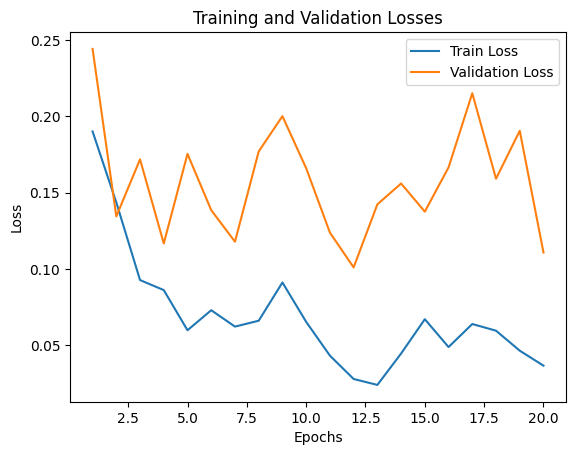

In [39]:
# Plotting
plt.plot(range(1, 21), train_losses, label='Train Loss')
plt.plot(range(1, 21), valid_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Top 10

In [21]:
model.load_state_dict(torch.load("best_model_triplet2.pt"))
print("Model Loaded")

Model Loaded


In [56]:
def euclidean_dist(img_enc, anc_enc_arr):
    dist = np.sqrt(np.dot(img_enc-anc_enc_arr, (img_enc - anc_enc_arr).T))
    return dist

In [58]:
import numpy as np
import pandas as pd
from skimage import io
import torch
from tqdm import tqdm
from PIL import Image  # Import Image from PIL

data_dir = "Homework5_dataset/"  
df = pd.read_csv("dataset_train.csv")  

anc_img_names = df["Anchor"].tolist()
anc_img_names_arr = np.array(anc_img_names)
encodings = []

model.eval()
with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
        # Using PIL to read the image
        A = Image.open(data_dir + i)
        A = np.array(A)  # Convert PIL image to NumPy array
        A = torch.from_numpy(A).permute(2, 0, 1) / 255.0
        A = A.to("cuda:0")
        A_enc = model(A.unsqueeze(0)) 
        encodings.append(A_enc.squeeze().cpu().detach().numpy())

encodings = np.array(encodings)
encodings_df = pd.DataFrame(encodings)
df_enc = pd.concat([pd.Series(anc_img_names, name="Anchor"), encodings_df], axis=1)

df_enc.to_csv("output.csv", index=False)

100%|██████████| 4000/4000 [00:12<00:00, 322.32it/s]


In [59]:
df_enc = pd.read_csv('output.csv')

In [60]:
import numpy as np
import torch
from skimage import io

def process_image(idx, df_enc, model, data_dir):
    img_name = df_enc["Anchor"].iloc[idx]
    img_path = data_dir + img_name

    img = io.imread(img_path)
    img = torch.from_numpy(img).permute(2, 0, 1) / 255.0

    model.eval()
    with torch.no_grad():
        img = img.to("cuda:0")
        img_enc = model(img.unsqueeze(0))
        img_enc = img_enc.detach().cpu().numpy()

    anc_enc_arr = df_enc.iloc[:, 1:].to_numpy()
    anc_img_names = df_enc["Anchor"]

    distance = []

    for i in range(anc_enc_arr.shape[0]):
        dist = euclidean_dist(img_enc, anc_enc_arr[i : i+1, :])
        distance = np.append(distance, dist)

    closest_idx = np.argsort(distance)

    return anc_img_names, data_dir, img, img_path, closest_idx, distance


In [61]:
import networkx as nx 
import matplotlib.pyplot as plt
from PIL import Image  

def load_image(image_path):
    # Use PIL to open the image
    image = Image.open(image_path)
    return image

def create_graph(anc_img_names, DATA_DIR, img_path, closest_idx, distance, no_of_closest=10):
    G = nx.Graph()

    S_name = [img_path.split('/')[-1]]

    for s in range(no_of_closest):
        S_name.append(anc_img_names.iloc[closest_idx[s]])

    for i, img_name in enumerate(S_name):
        image = load_image(DATA_DIR + img_name)
        G.add_node(i, image=image)

    for j in range(1, no_of_closest + 1):
        G.add_edge(0, j, weight=distance[closest_idx[j - 1]])

    return G, S_name


def plot_graph(G, S_name):
    pos = nx.kamada_kawai_layout(G)

    fig, ax = plt.subplots(figsize=(20, 20))
    ax.set_aspect('equal')
    nx.draw_networkx_edges(G, pos, ax=ax)

    plt.xlim(-1.5, 1.5)
    plt.ylim(-1.5, 1.5)

    trans = ax.transData.transform
    trans2 = fig.transFigure.inverted().transform

    piesize = 0.1  # this is the image size
    p2 = piesize / 2.0
    for n in G:
        xx, yy = trans(pos[n])  # figure coordinates
        xa, ya = trans2((xx, yy))  # axes coordinates
        a = plt.axes([xa - p2, ya - p2, piesize, piesize])
        a.set_aspect('equal')
        a.imshow(G.nodes[n]['image'])
        a.set_title(S_name[n][0:4])
        a.axis('off')

    ax.axis('off')
    plt.show()


def plot_closest_imgs(anc_img_names, DATA_DIR, img_path, closest_idx, distance, no_of_closest=10):
    G, S_name = create_graph(anc_img_names, DATA_DIR, img_path, closest_idx, distance, no_of_closest)
    plot_graph(G, S_name)

In [75]:
result = process_image(10, df_enc, model, data_dir)
anc_img_names, data_dir, img, img_path, closest_idx, distance = result

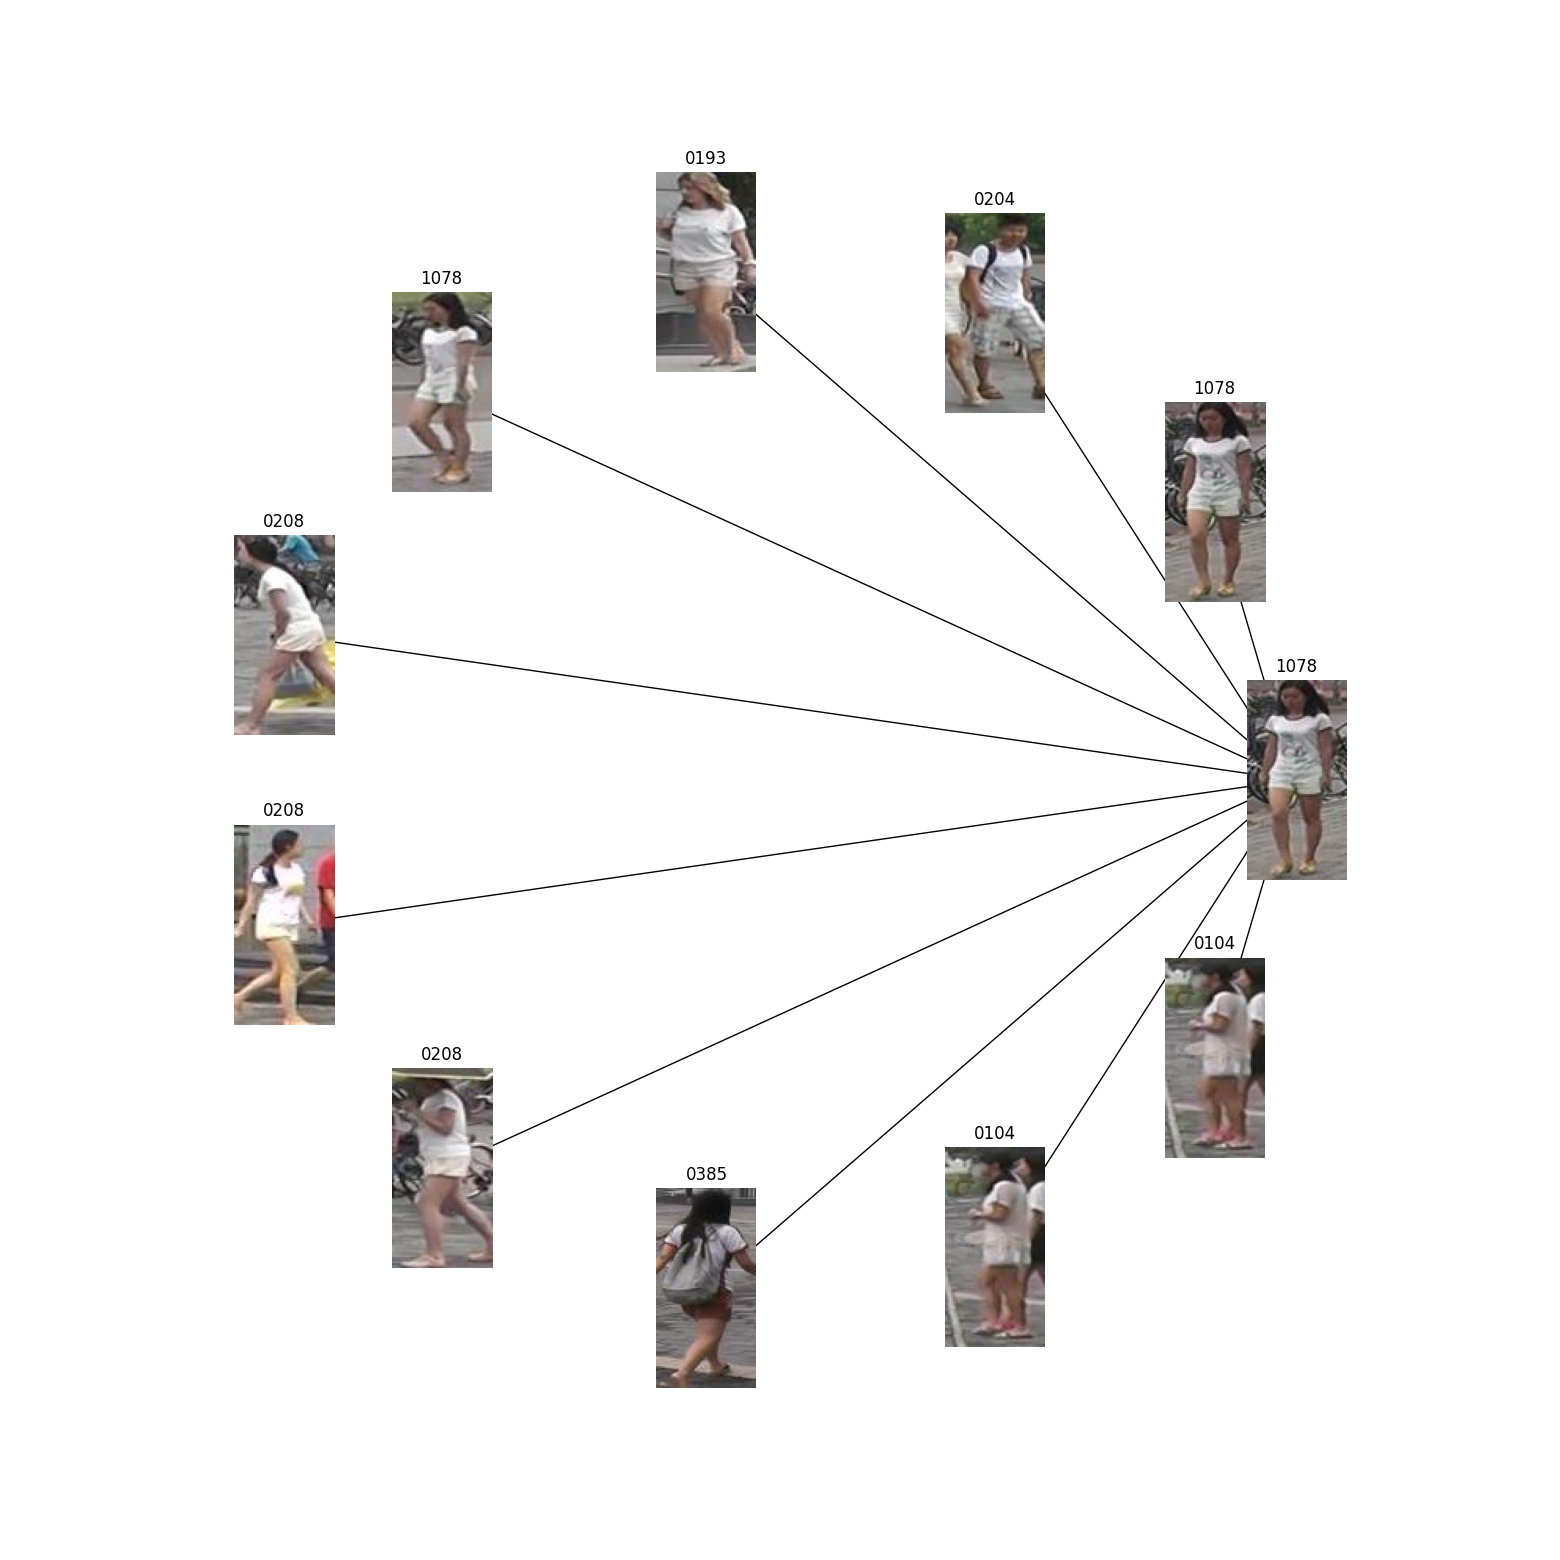

In [77]:
plot_closest_imgs(anc_img_names, data_dir, img_path, closest_idx, distance, no_of_closest=10)


In [78]:
result = process_image(20, df_enc, model, data_dir)
anc_img_names, data_dir, img, img_path, closest_idx, distance = result

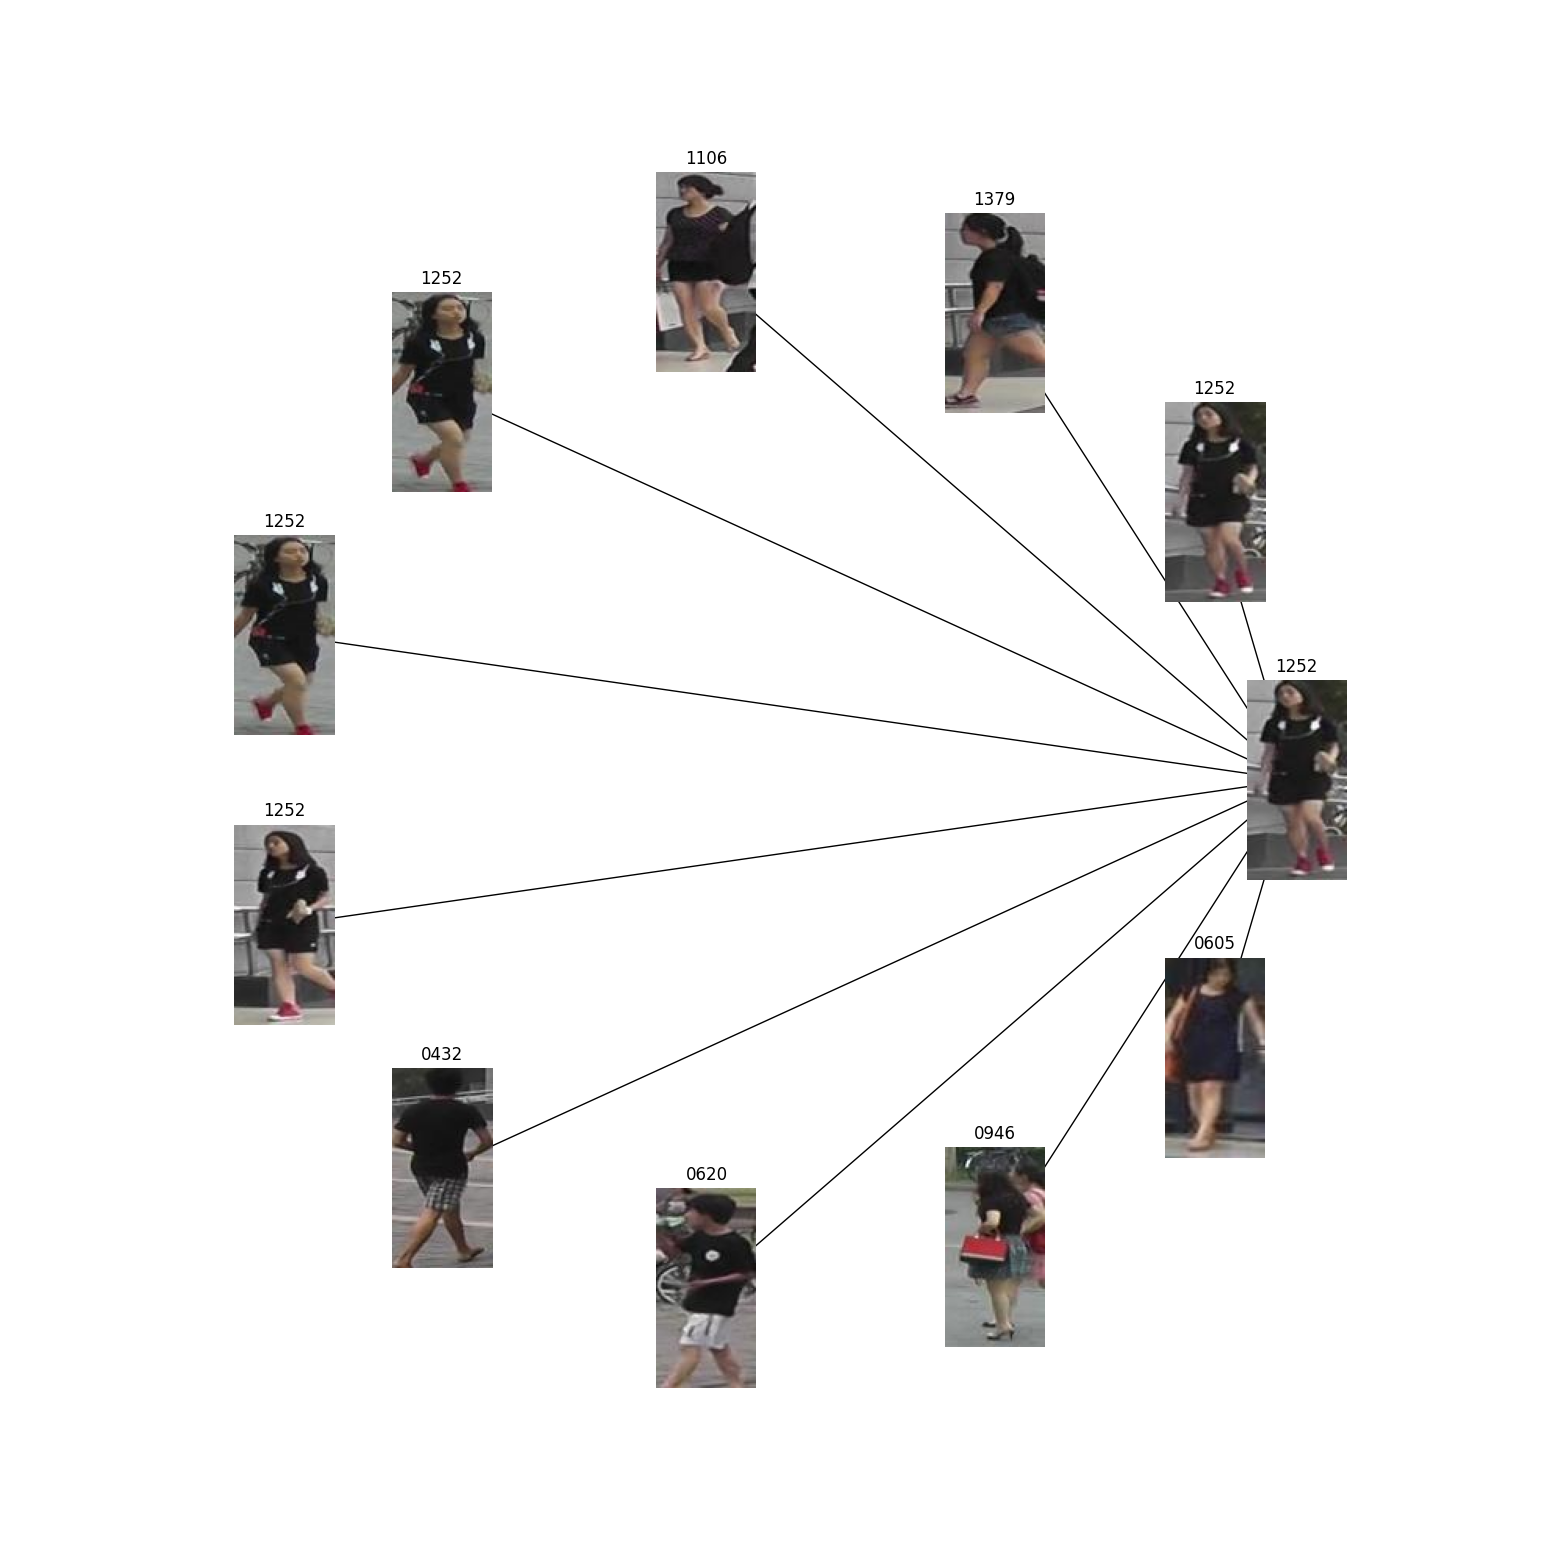

In [79]:
plot_closest_imgs(anc_img_names, data_dir, img_path, closest_idx, distance, no_of_closest=10)

In [62]:
data_dir = "Homework5_dataset/"  


# ROC

In [33]:
model.load_state_dict(torch.load("best_model_triplet2.pt"))
print("Model Loaded")

Model Loaded


In [34]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print("model loaded")

model loaded


In [35]:
# Function to calculate similarity scores
def calculate_similarity(embedding1, embedding2):
    # Cosine similarity is a common choice
    return torch.nn.functional.cosine_similarity(embedding1, embedding2).cpu().numpy()


# Prepare data for ROC
similarity_scores = []
true_labels = []

with torch.no_grad():
    for batch in valid_loader:
        anchor_images, positive_images, negative_images = batch  
        anchor_images, positive_images, negative_images = anchor_images.to(device), positive_images.to(device), negative_images.to(device)

        # Forward pass for anchor-positive pairs
        anchor_embeddings = model(anchor_images)
        positive_embeddings = model(positive_images)
        scores_positive = calculate_similarity(anchor_embeddings, positive_embeddings)
        similarity_scores.extend(scores_positive)
        true_labels.extend([1] * len(scores_positive))  # 1 for similar

        # Forward pass for anchor-negative pairs
        negative_embeddings = model(negative_images)
        scores_negative = calculate_similarity(anchor_embeddings, negative_embeddings)
        similarity_scores.extend(scores_negative)
        true_labels.extend([0] * len(scores_negative))  # 0 for not similar

In [36]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(true_labels, similarity_scores)
roc_auc = auc(fpr, tpr)

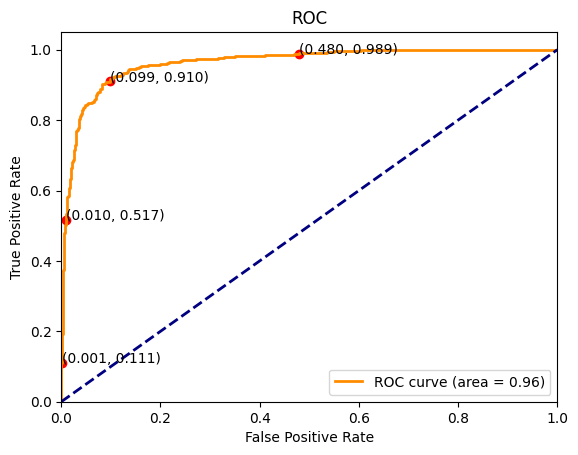

In [48]:
# Function to find closest index in an array to a given value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Desired FPR values
desired_fprs = [0.5, 0.1, 0.01, 0.001]

# Find nearest FPRs and corresponding TPRs
nearest_fprs = [fpr[find_nearest(fpr, desired_fpr)] for desired_fpr in desired_fprs]
nearest_tprs = [tpr[find_nearest(fpr, desired_fpr)] for desired_fpr in desired_fprs]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Annotate desired points
for fpr_point, tpr_point in zip(nearest_fprs, nearest_tprs):
    plt.scatter(fpr_point, tpr_point, color='red')
    plt.text(fpr_point, tpr_point, f'({fpr_point:.3f}, {tpr_point:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

In [23]:
# Function to calculate similarity scores
def calculate_similarity(embedding1, embedding2):
    # Cosine similarity is a common choice
    return torch.nn.functional.cosine_similarity(embedding1, embedding2).cpu().numpy()


# Prepare data for ROC
similarity_scores = []
true_labels = []

with torch.no_grad():
    for batch in train_loader:
        anchor_images, positive_images, negative_images = batch  
        anchor_images, positive_images, negative_images = anchor_images.to(device), positive_images.to(device), negative_images.to(device)

        # Forward pass for anchor-positive pairs
        anchor_embeddings = model(anchor_images)
        positive_embeddings = model(positive_images)
        scores_positive = calculate_similarity(anchor_embeddings, positive_embeddings)
        similarity_scores.extend(scores_positive)
        true_labels.extend([1] * len(scores_positive))  # 1 for similar

        # Forward pass for anchor-negative pairs
        negative_embeddings = model(negative_images)
        scores_negative = calculate_similarity(anchor_embeddings, negative_embeddings)
        similarity_scores.extend(scores_negative)
        true_labels.extend([0] * len(scores_negative))  # 0 for not similar

In [25]:
from sklearn.metrics import roc_curve, auc
# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(true_labels, similarity_scores)
roc_auc = auc(fpr, tpr)

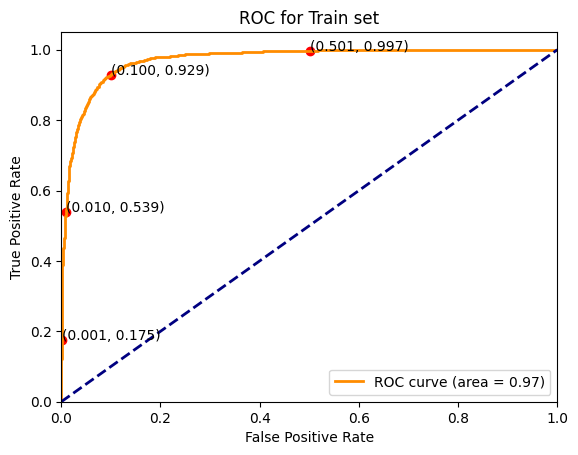

In [26]:
# Function to find closest index in an array to a given value
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

# Desired FPR values
desired_fprs = [0.5, 0.1, 0.01, 0.001]

# Find nearest FPRs and corresponding TPRs
nearest_fprs = [fpr[find_nearest(fpr, desired_fpr)] for desired_fpr in desired_fprs]
nearest_tprs = [tpr[find_nearest(fpr, desired_fpr)] for desired_fpr in desired_fprs]

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Annotate desired points
for fpr_point, tpr_point in zip(nearest_fprs, nearest_tprs):
    plt.scatter(fpr_point, tpr_point, color='red')
    plt.text(fpr_point, tpr_point, f'({fpr_point:.3f}, {tpr_point:.3f})')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC for Train set')
plt.legend(loc="lower right")
plt.show()

# Similarity Accuracy

In [10]:
model.load_state_dict(torch.load("best_model_triplet2.pt"))
print("Model Loaded")

Model Loaded


In [13]:
import torch
from tqdm import tqdm

device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")

# Initialize counters for correct and total pairs
correct_pairs = 0
total_pairs = 0

model.eval()

with torch.no_grad():
    for A, P, N in tqdm(valid_loader):
        pass
        A, P, N = A.to(device), P.to(device), N.to(device)

        # Forward pass to get embeddings
        emb_A = model(A)
        emb_P = model(P)
        emb_N = model(N)

        # Compute Euclidean distances
        dist_pos = torch.norm(emb_A - emb_P, dim=1)
        dist_neg = torch.norm(emb_A - emb_N, dim=1)

        # Check if the distance of the positive pair is smaller than the distance of the negative pair
        correct_pairs += torch.sum(dist_pos < dist_neg).item()
        total_pairs += A.size(0)  # Batch size

# Calculate similarity accuracy
similarity_accuracy = correct_pairs / total_pairs

print(f"Similarity Accuracy: {similarity_accuracy * 100:.2f}%")


100%|██████████| 25/25 [00:00<00:00, 217.92it/s]

Similarity Accuracy: 98.00%
